#### Jeremy's Lecture 3 of Cuda Mode

##### The original notebook is here - https://github.com/cuda-mode/lectures?tab=readme-ov-file#lecture-3
##### I am re-implementing for my practice

In [31]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/43/Cute_dog.jpg/1600px-Cute_dog.jpg?20140729055059'

In [32]:
# Import all necessary libraries
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

###### Converting RGB to gray
###### Recommended: L = 0.21* Red + 0.72* Green + 0.07*Blue



In [33]:
path_img = Path('puppy.jpg')
if not path_img.exists(): urlretrieve(url, path_img)

In [34]:
img = io.read_image('puppy.jpg')
print(img.shape)
# first channel, first 3 rows and first 4 columns
img[:2,:3,:4]

torch.Size([3, 1066, 1600])


tensor([[[117, 119, 117, 113],
         [119, 129, 129, 113],
         [130, 126, 122, 115]],

        [[ 83,  85,  85,  80],
         [ 85,  97,  97,  82],
         [ 98,  93,  89,  83]]], dtype=torch.uint8)

In [35]:
def show_img(x, fig_size=(4,3), **kwargs):
    plt.figure(figsize=fig_size)
    plt.axis('off')
    if len(x.shape) ==  3:
        # permutation is not an in-place operation
        x = x.permute(1, 2, 0) # Pytorch CHW -> Matplotlib HWC
    plt.imshow(x.cpu(), **kwargs)

In [36]:
# 150 height, reshaped to avoid more computations
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 225, 33750)

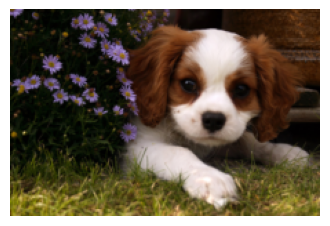

In [37]:
show_img(img2)

RGB to grayscale naive way -> flatten the image and for every pixel apply the formula?

In [38]:
# written in python
def rgb2grey_py(x):
   c, h, w = x.shape
   total_pixels = h*w
   x = x.flatten() # flatten is also not in-place
   # result = [0]*(total_pixels) # this is naive way
   result = torch.empty(total_pixels, dtype=x.dtype, device=x.device) # better way to initialize variable
   # this is something that is independent and can be parallalized!!
   for i in range(total_pixels):
    result[i] = (0.21) * x[i] + (0.72)* x[i+total_pixels] + (0.07) * x[i+2*total_pixels] #r, g, b
   return result.view(h, w)

In [39]:
%%time
img_g = rgb2grey_py(img2) # we are measuring wall-time because we need to observe 
# the improvement while using CUDA 

CPU times: user 585 ms, sys: 0 ns, total: 585 ms
Wall time: 584 ms


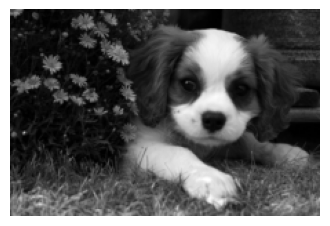

In [40]:
show_img(img_g, cmap='gray')

So to speed this multiplication, we can use CUDA!
To do so, we need to define the CUDA kernel! And they won't/can't return anything!!

In the above code, the logic that needs to be executed a lots of time is the for loop! And that has some independency, so it can be run a lot of times. So, we need to write a kernel for that! 

### Writing in Python Kernel (without any blocks)

In [41]:
# CUDA kernel (native python way)!!
# NOTE: A kernel can not return anything. It can only change contents of things passed to it.
def run_kernel(f, times, *args):
    for i in range(times):
        f(i, *args)

In [42]:
def rgb2grey_k(i, x, out, n):
    # This is something that can be run parallely!!
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [43]:
def rgb2grey_pyk(x):
    c, h, w = x.shape
    total_pixels = h*w
    x = x.flatten()
    result = torch.empty(total_pixels, dtype=x.dtype, device=x.device)
    # instead of writing the for loop, call the kernel here!
    # the function we want to run multiple times can be present in this kernel!
    # except the function name, the rest are zipped as args and will again be dezipped! 
    run_kernel(rgb2grey_k, total_pixels, x, result, total_pixels)
    return result.view(h, w)

In [44]:
%%time
img_g = rgb2grey_pyk(img2) # Wall-time while using Python way of CUDA
# not much of a speed-up actually, because we didn't pass these to SMs(Streaming Multiprocessors)
# and different cores

CPU times: user 585 ms, sys: 0 ns, total: 585 ms
Wall time: 585 ms


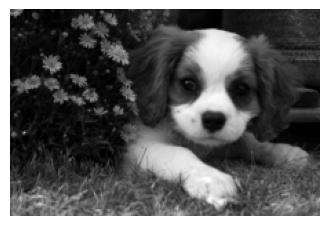

In [45]:
show_img(img_g, cmap='gray')

The above one is identical to how we write CUDA! It is not written in CUDA but the idea is very close!

One thing that is still missing is, if the for loop is done for 1000 times, it's not like 1000 contagious memory is issued for CUDA. It executes in "BLOCKS"

So, modify the above code to support blocks

### Writing in Python blocks

In [46]:
# CUDA kernel (native python way)!!
# NOTE: A kernel can not return anything. It can only change contents of things passed to it.
# Now, write in blocks so it looks very similar to how we want to write
# (total number of times ~ blocks * threads) (the last combination might not have all elements)
# just like drop_last_batch!
def run_kernel_blocks(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads):
            f(i, j, threads, *args) # we need threads to make sure to check for last loop

In [47]:
def rgb2gray_blk_kernel(curr_block, curr_thread, total_threads, x, output, total_pixels_per_channel):
    i = curr_block * total_threads + curr_thread # this will give where i is located!
    if i < total_pixels_per_channel: # this is called "GUARD"
        output[i] = 0.2989*x[i] + 0.5870*x[i+total_pixels_per_channel] + 0.1140*x[i+2*total_pixels_per_channel]


In [48]:
def rgb2_gray_py_blk(x):
    c, h, w = x.shape
    total_pixels = h * w
    x = x.flatten()
    output = torch.empty(total_pixels, dtype = x.dtype, device = x.device)
    threads = 256 # in practice
    blocks = int(math.ceil(total_pixels/threads))
    run_kernel_blocks(rgb2gray_blk_kernel, blocks, threads, x, output, total_pixels) 
    return output.view(h, w)

CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 636 ms


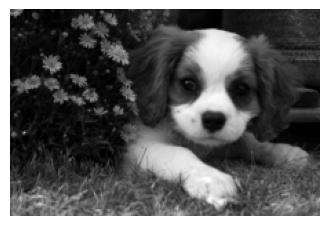

In [49]:
%%time
img_g = rgb2_gray_py_blk(img2) # Wall-time while using Python way of CUDA with blocks
# not much of a speed-up actually, because we didn't pass these to SMs(Streaming Multiprocessors)
# and different cores
show_img(img_g, cmap='gray')

### CUDA setup (convert Pythonic thread/blocks -> CUDA)
The above code needs to be given in Streaming Multiprocessors

In [50]:
os.environ['CUDA_LAUNCH_BLOCKING']='1' #if an error occurs, stop. useful for debugging

In [51]:
# !pip install -q wurlitzer ninja

In [52]:
%load_ext wurlitzer 
# this is used to print statements to debug things in CUDA for Notebook

The wurlitzer extension is already loaded. To reload it, use:
  %reload_ext wurlitzer


To run the CUDA code in Pytorch, it has a module named load_inline

Just pass the CUDA source code we want to execute, cpp code we want to execute and the functions we might need!

In [53]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

define a string to include what all we want to use to compile our code

we have to check that the input is in CUDA and has continuous memory!

In [54]:
cuda_begin = r'''
#include <stdio.h>
#include <torch/extension.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

The code we want to parallalize, add it as a function to the cuda_begin

#uint8 in pytorch -> unsigned char!! * means x is an array in bytes because RGB is just 0-255 thus 8 bits is enough!

Dunder declaration

__global__ -> Call it on either CPU or GPU, execute on GPU

__device__ -> Call it on GPU, execute on GPU

__host__ (default) -> Call it on CPU, execute on CPU

<<< blocks, threads >>> -> "<<<>>>" makes sure to call the kernel on GPU, and we need to pass the blocks and threads!

In [55]:
cuda_src = cuda_begin + r'''
__global__ void rgb2gray_blk_kernel(unsigned char* x, unsigned char* output, int total_pixels_per_channel) {
    int i = blockIdx.x * blockDim.x + threadIdx.x; # This will give where i is located!

    if (i < total_pixels_per_channel) { #This is called "GUARD"
        output[i] = 0.2989 * x[i] + 0.5870 * x[i + total_pixels_per_channel] + 0.1140 * x[i + 2 * total_pixels_per_channel];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input){
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w = %d*%d\n", h, w);
    auto output = torch::empty({h, w}, input.options());
    int threads = 256;
    rgb2gray_blk_kernel<<cdiv(w*h, threads), threads>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}

'''

In [56]:
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

I am getting some CUDA error, but this is the code! 

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

In [ ]:
dir(module) #gives all the functions present in the CUDA mode!

Once the CUDA function is created, we can pass our input to observe the speedups
We need to make sure our input is contiguous and on CUDA before passing the input to function

In [59]:
imgc = img.contiguous().cuda()

For timing, using cpu() is better because it will synchronize the processes i.e it makes sure that the entire GPU process is completed and moved to CPU.
Otherwise, the GPU process might be running but we will get final answer which wont give true picture!

In [ ]:
### Passing the complete image; still this is faster 
# (takes aroun 1ms compared to 700ms of previous function which runs only downsampled image)
%%time
result =  module.rgb_to_grayscale(imgc).cpu()
h, w = result.shape
h, w, h*w

In [ ]:
show_img(result, cmap='gray')

#### Example 2 - Matrix Multiplication

Do matrix multiplication for MNIST dataset!

In [98]:
import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

In [99]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [100]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [101]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

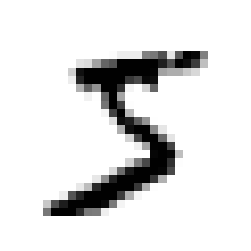

In [102]:
show_img(imgs[0], cmap='gray_r')

In [103]:
torch.manual_seed(1)
weights = torch.randn(784, 10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

Python way of matrix multiplication

In [104]:
matrix1 = x_valid[:5]
matrix2 = weights
matrix1.shape, matrix2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [105]:
m1_rows, m1_cols = matrix1.shape
m2_rows, m2_cols = matrix2.shape
output = torch.zeros(m1_rows, m2_cols)

In [106]:
for row in range(m1_rows): # 5
    for col in range(m2_cols): # 10
        for idx in range(m1_cols): #784
            output[row, col] += matrix1[row, idx] * matrix2[idx, col]

In [107]:
output.shape

torch.Size([5, 10])

In [108]:
def matmul(a, b):
    (ar, ac), (br, bc) = a.shape, b.shape
    c = torch.zeros(ar, bc) # final matrix shape
    for row in range(ar): # 5
        for col in range(bc): # 10
            for idx in range(ac): #784
                c[row, col] += a[row, idx] * b[idx, col]
    return c

In [109]:
%%time
matmul(matrix1, matrix2)

CPU times: user 343 ms, sys: 0 ns, total: 343 ms
Wall time: 342 ms


tensor([[-10.9417,  -0.6844,  -7.0038,  -4.0066,  -2.0857,  -3.3588,   3.9127,
          -3.4375, -11.4696,  -2.1153],
        [ 14.5430,   5.9977,   2.8914,  -4.0777,   6.5914, -14.7383,  -9.2787,
           2.1577, -15.2772,  -2.6758],
        [  2.2204,  -3.2171,  -4.7988,  -6.0453,  14.1661,  -8.9824,  -4.7922,
          -5.4446, -20.6758,  13.5657],
        [ -6.7097,   8.8998,  -7.4611,  -7.8966,   2.6994,  -4.7260, -11.0278,
         -12.9776,  -6.4443,   3.6376],
        [ -2.4444,  -6.4034,  -2.3984,  -9.0371,  11.1772,  -5.7724,  -8.9214,
          -3.7862,  -8.9827,   5.2797]])

total number of operations are: ar * bc * ac

#### 2D Python Kernel

We can create a 2D kernel by kernalizing the innermost for loop in matmul(). For that, we can index using blocks and threads in 2D fashion.

Assume block size is 16x16

Block idx - (3, 4)
Thread idx - (6, 12)

will give a CUDA thread which is present in ((16 * (3+1)) + 6, (16 * (4 + 1)) + 12) = (70, 92) assuming there's a 2D grid with 0, 0 on top-left

We can also create a 3D kernel i.e take the 2 inner loops

In [110]:
from types import SimpleNamespace as ns

In [111]:
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x):
                    f(ns(x=i1, y=i0), ns(x=j1, y=j0), threads, *args) # give blockidx and threadidx to function!


In [122]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    # we DON'T return from kernel!
    # blockdim is same as tpb which is 16x16!
    # k is the common dimension!

    # TODO: Verify if it's x or y for row! (go to the specific thread!)
    r = blockidx.y * blockdim.y + threadidx.y 
    c = blockidx.x * blockdim.x + threadidx.x

    # Guard to check out of dimensions!
    if r >= h or c >= w:
        return
    o = 0.
    for i in range(k):
        o += m[r*k + i] * n[i*w + c]
    out[r*w + c] = o

Threads per block (tpb) usually can't be more than 1024 and good practice to use multiple of 32

Max blocks are 2^31 for dim 0 and 2^16 for dim 1 and dim 2

In [123]:
def matmul_2d(m, n):
    h, k = m.shape
    k2, w = n.shape
    assert k == k2, "Size mismatch!"
    output = torch.zeros(h, w, dtype=m.dtype) # output array to store!
    # threads per block! for this eg it's a 2D aligned thread-block
    tpb = ns(x=16, y=16)
    # number of blocks will be dim of input divided to threads!
    # TODO: Have to verify if it's correct i.e is it h/x or w/x
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb, m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [124]:
%%time
res = matmul_2d(matrix1, matrix2)

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 144 ms


In [125]:
torch.isclose(res, output).all()

tensor(True)

#### Broadcasting (Python way of fast multiplication, just to compare with CUDA one interms of speed!)

In [127]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c
     

In [130]:
torch.isclose(output,matmul(matrix1, matrix2)).all()

tensor(True)

In [132]:
%time _=matmul(matrix1, matrix2)

CPU times: user 1.33 ms, sys: 3.82 ms, total: 5.14 ms
Wall time: 5.01 ms


In [134]:
matrix1 = x_train
tr = matmul(matrix1, matrix2)
tr.shape

torch.Size([50000, 10])

In [136]:
%time _=matmul(matrix1, matrix2)

CPU times: user 637 ms, sys: 0 ns, total: 637 ms
Wall time: 570 ms


In [137]:
ar,ac = matrix1.shape
br,bc = matrix2.shape
ar*bc*ac

392000000

#### CUDA Kernel for matrix multiplication

m, n, o are arrays having floats! so declare them as float pointers
dim3 -> datatype similar to tuple with 3 elements!

Because we flatten the arrays, we do r*k + i to get the element!

In [138]:
cuda_src = cuda_begin + r'''
___global___ void matmul_bk(float* m, float* n, float* out, int h, int w, int k){
    int r = blockIdx.y * blockDim.y + threadIdx.y; 
    int c = blockIdx.x * blockDim.x + threadIdx.x;

    if (r >= h || c >= w) return;
    float o = 0;
    for (int i=0; i <= k; ++i) {
        o += m[r*k + i] * n[i*w + c];
    }
    out[r*w + c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n){
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k == n.size(0), "Size mismatch");

    auto output = torch::zeros({h, w}, m.options()); 
    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    
    matmul_bk<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k
    );
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [139]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [140]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

RuntimeError: Error building extension 'inline_ext_v1': [1/3] /usr/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/TH -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/THC -isystem /hdd4/srinath2/.conda/envs/llm_env/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -std=c++17 -c /hdd4/srinath2/.cache/torch_extensions/py312_cu121/inline_ext/cuda.cu -o cuda.cuda.o 
[31mFAILED: [0mcuda.cuda.o 
/usr/bin/nvcc --generate-dependencies-with-compile --dependency-output cuda.cuda.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/TH -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/THC -isystem /hdd4/srinath2/.conda/envs/llm_env/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERSIONS__ -D__CUDA_NO_BFLOAT16_CONVERSIONS__ -D__CUDA_NO_HALF2_OPERATORS__ --expt-relaxed-constexpr -gencode=arch=compute_86,code=compute_86 -gencode=arch=compute_86,code=sm_86 --compiler-options '-fPIC' -std=c++17 -c /hdd4/srinath2/.cache/torch_extensions/py312_cu121/inline_ext/cuda.cu -o cuda.cuda.o 
cc1plus: fatal error: cuda_runtime.h: No such file or directory
compilation terminated.
[2/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext_v1 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/torch/csrc/api/include -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/TH -isystem /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/torch/include/THC -isystem /hdd4/srinath2/.conda/envs/llm_env/include/python3.12 -D_GLIBCXX_USE_CXX11_ABI=0 -fPIC -std=c++17 -c /hdd4/srinath2/.cache/torch_extensions/py312_cu121/inline_ext/main.cpp -o main.o 
ninja: build stopped: subcommand failed.


In [142]:
m1c,m2c = matrix1.contiguous().cuda(), matrix2.contiguous().cuda()

In [ ]:
torch.isclose(tr,module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

In [ ]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

Optimized broadcasting code takes 1sec while CUDA takes 6ms on avg!

### Pytorch way (faster, more optimized one)
They are using Shared Memory more efficiently!

In [148]:
torch.isclose(tr.cuda(), m1c@m2c, atol=1e-5).cpu().all()

tensor(True)

In [149]:
%timeit -n 10 _=(m1c@m2c).cpu()

4.37 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### RGB -> Grayscale CUDA 3D kernel
It's not always needed to use 2D or 3D blocks. We can simply use 1D blocks if we want to!
For example, the RGB->Gray can be done using 2D Kernels as well

Because we flatten the arrays, we need to use r*w + i. Think of 2D array converting to 1D list!

In [ ]:
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int w, int h){
    int c = blockIdx.x * blockDim.x + threadIdx.x;
    int r = blockIdx.y * blockDim.y + threadIdx.y;

    if (c < w && r < h){
        int i = r*w + c;
        int n = h*w;
        out[i] = 0.289*x[i] + 0.587*x[i+n] + 0.114*x[i+2*n];
    }
}

torch::Tensor rgb_to_grayscale(torch::Tensor input){
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    torch::Tensor output = torch::empty({h, w}, input.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(h, tpb.x), cdiv(w, tpb.y));
    rgb_to_grayscale_kernel<<<blocks, tpb>>>{
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), int w, int h
    };
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [ ]:
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'])

In [ ]:
res = module.rgb_to_grayscale(imgc).cpu()
show_img(res, cmap='gray')